# XGBoost

In [8]:
import matplotlib.pyplot as plt

In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from pathlib import Path

# Définition du chemin principal vers les données (à adapter selon votre environnement)
data_dir_dam = Path("C:/Users/tagla/Downloads/datbi2025-cancer-main/datbi2025-cancer-main/DataSets") # replace with your own path
# Chemin vers les fichiers de features extraits par MoCo (Self-Supervised Learning)
features_dir = data_dir_dam / "train_input/moco_features"
# Chemin vers le fichier contenant les labels (ground truth)
labels_dir = data_dir_dam / "train_output.csv"

# Chargement du fichier CSV contenant les labels associés aux échantillons
labels = pd.read_csv(labels_dir)

labels.columns = labels.columns.str.strip()

# On définit "Sample ID" comme index pour faciliter les jointures futures avec les features
labels.set_index("Sample ID", inplace=True)

In [2]:
# Initialisation des listes pour stocker les features (X) et les labels (y)
X = []
y = []

# Parcours de chaque échantillon à partir du DataFrame des labels
for sample_id, row in labels.iterrows():
    # Construction du chemin vers le fichier .npy correspondant aux features du sample
    path = os.path.join(features_dir, f"{sample_id}")

    # Vérification que le fichier existe
    if not os.path.exists(path):
        print(f"File not found: {path}")
        continue  # Si le fichier est manquant, on passe à l’échantillon suivant

    # Chargement des features sous forme de matrice numpy
    mat = np.load(path)                  # shape: (1000, 2051)
    # Suppression des 3 premières colonnes (identifiants ou métadonnées), on garde les 2048 features
    features = mat[:, 3:]                # only use last 2048 columns
    # Moyenne sur l’ensemble des "tiles" (sous-images) pour obtenir un vecteur unique par échantillon
    aggregated = features.mean(axis=0)   # average over tiles

    # Ajout des features et du label à leurs listes respectives
    X.append(aggregated)
    y.append(row["Target"])

# Conversion des listes en tableaux numpy pour traitement ultérieur
X = np.array(X)
y = np.array(y)


In [3]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred_proba)

print(f"AUC ROC : {auc:.4f}")

C:\Users\tagla\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\xgboost\training.py:183: UserWarning: [10:12:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


AUC ROC : 0.6100


AUC ROC : 0.6212


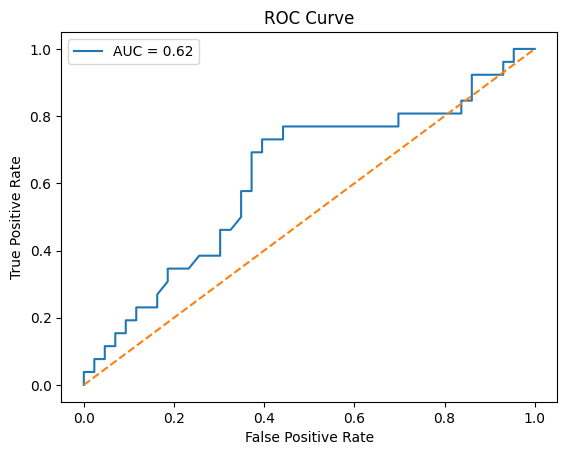

In [10]:
from sklearn.ensemble import RandomForestClassifier

model_randFor = RandomForestClassifier(n_estimators=1000, random_state=42)

model_randFor.fit(X_train, y_train)

y_pred_proba_rf = model_randFor.predict_proba(X_val)[:, 1]
auc_rf = roc_auc_score(y_val, y_pred_proba_rf)

print(f"AUC ROC : {auc_rf:.4f}")

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Calcul des taux de faux positifs (fpr) et vrais positifs (tpr)
# à partir des probabilités prédites
fpr, tpr, _ = roc_curve(y_val, y_pred_proba_rf)

# Tracé de la courbe ROC
plt.plot(fpr, tpr, label=f"AUC = {auc_rf:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')

# Étiquettes des axes et titre du graphique
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")

# Affichage de la légende (incluant la valeur AUC)
plt.legend()
plt.show()